[*                      2%                       ]  11 of 503 completed

Number of tickers in SPY universe: 503


[*********************100%***********************]  503 of 503 completed


Downloaded data for 503 tickers.
Formation date for portfolio construction: 2025-03-04 00:00:00
Latest 30-day skewness at formation date (sample):
 Ticker
A      -0.123629
AAPL   -0.103445
ABBV    0.815877
ABNB    2.321486
ABT     0.213954
Name: 2025-03-04 00:00:00, dtype: float64
Long positions (lowest skewness): ['FMC', 'WST', 'SWKS', 'SRE', 'AKAM', 'TFX', 'UPS', 'VTRS', 'CMCSA', 'HOLX', 'DECK', 'GDDY', 'FIS', 'PTC', 'PYPL', 'CE', 'NTAP', 'EA', 'HII', 'DHR', 'FE', 'IEX', 'BBY', 'MDT', 'ETN', 'PKG', 'MKTX', 'PWR', 'LMT', 'BDX', 'NOW', 'EBAY', 'GWW', 'DVA', 'EPAM', 'MRK', 'CEG', 'TT', 'EL', 'KMI', 'AVGO', 'ANET', 'PEG', 'CSCO', 'RMD', 'JNPR', 'MSCI', 'DLR', 'GEV', 'EFX', 'PODD', 'NWSA', 'JBL', 'NWS', 'VST', 'AMP', 'STT', 'WAB', 'HUBB', 'FRT', 'INCY', 'BG', 'CLX', 'HPQ', 'CHRW', 'IR', 'ZBH', 'LII', 'CHTR', 'SYY', 'LYV', 'BALL', 'APH', 'EQT', 'VLTO', 'CDNS', 'UNH', 'EQIX', 'NVDA', 'FDX', 'F', 'AVY', 'MTCH', 'PG', 'ALLE', 'IFF', 'DAY', 'KKR', 'CAH', 'HON', 'ACN', 'IRM', 'ORCL', 'LDOS', 'A

C:\Users\jeurc\AppData\Local\Temp\ipykernel_2228\1466274462.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[stock] = 1.0 / len(long_stocks)


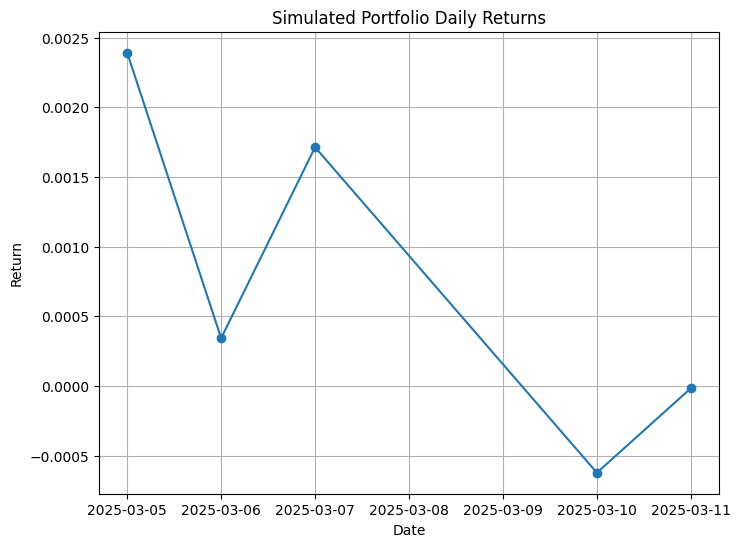

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
# inspired from paper: https://www.sciencedirect.com/science/article/pii/S0304405X15001257#s0140
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_tables = pd.read_html(sp500_url)
sp500_df = sp500_tables[0] 
tickers = sp500_df['Symbol'].tolist()
tickers = [ticker.replace('.', '-') for ticker in tickers]
print(f"Number of tickers in SPY universe: {len(tickers)}")
data = yf.download(tickers, period='6mo', interval='1d')['Close']
data = data.dropna(axis=1, how='all')
print(f"Downloaded data for {data.shape[1]} tickers.")
returns = data.pct_change().dropna()
lookback = 30
rolling_skew = returns.rolling(window=lookback).apply(lambda x: skew(x), raw=True).dropna()


# instead of using the last available date (which leaves no future data), we select a formation date a few days earlier (e.g., the 6th-to-last date)
formation_date = rolling_skew.index[-6]
latest_skew = rolling_skew.loc[formation_date]
print("Formation date for portfolio construction:", formation_date)
print("Latest 30-day skewness at formation date (sample):\n", latest_skew.head())

# rank stocks by skewness. assume that lower (more negative) skewness is a signal for higher future returns.
ranked = latest_skew.sort_values()

n = len(ranked)
group_size = max(1, int(0.3 * n))
long_stocks = ranked.iloc[:group_size].index.tolist()   # bottom 30% lowest skewness
short_stocks = ranked.iloc[-group_size:].index.tolist()  # top 30% highest skewness

print("Long positions (lowest skewness):", long_stocks)
print("Short positions (highest skewness):", short_stocks)

weights = pd.Series(0, index=ranked.index)
for stock in long_stocks:
    weights[stock] = 1.0 / len(long_stocks)
for stock in short_stocks:
    weights[stock] = -1.0 / len(short_stocks)
print("Portfolio Weights (sample):\n", weights.head(10))

formation_idx = returns.index.get_loc(formation_date)
if formation_idx + 6 > len(returns.index):
    raise ValueError("Not enough future data available from the chosen formation date.")
future_dates = returns.index[formation_idx + 1 : formation_idx + 6]
future_returns = returns.loc[future_dates]
common_tickers = list(weights.index.intersection(returns.columns))
portfolio_daily_returns = future_returns[common_tickers].dot(weights[common_tickers])

print("Portfolio Daily Returns:\n", portfolio_daily_returns)


cumulative_return = (1 + portfolio_daily_returns).prod() - 1
print(f"Cumulative return over next 5 days: {cumulative_return:.2%}")


plt.figure(figsize=(8, 6))
plt.plot(future_dates, portfolio_daily_returns, marker='o')
plt.title("Simulated Portfolio Daily Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.grid(True)
plt.show()


Average Realized Skewness by Sampling Frequency:
Interval 1 minute(s): -0.0004
Interval 2 minute(s): 0.0004
Interval 5 minute(s): -0.0019
Interval 10 minute(s): -0.0003
Interval 15 minute(s): 0.0006
Interval 30 minute(s): -0.0002

Average Realized Excess Kurtosis by Sampling Frequency:
Interval 1 minute(s): 0.5653
Interval 2 minute(s): 0.3802
Interval 5 minute(s): 0.1798
Interval 10 minute(s): 0.0765
Interval 15 minute(s): 0.0562
Interval 30 minute(s): 0.0342


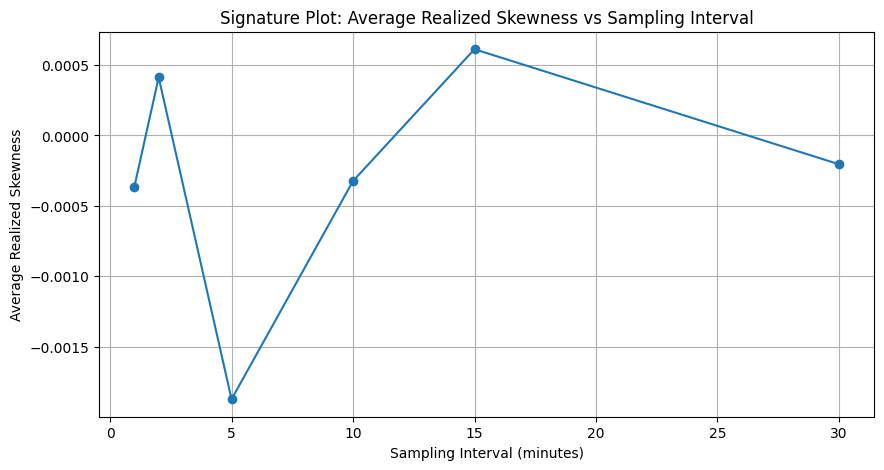

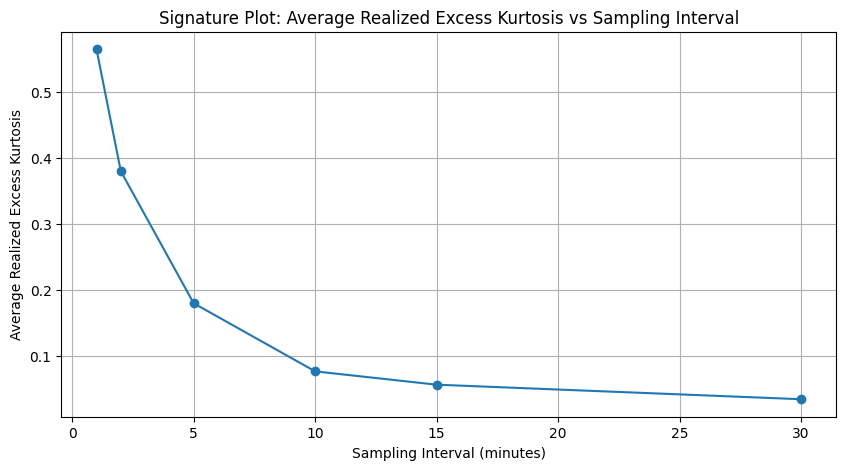

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew


num_paths = 5000      # number of Monte Carlo simulations (paths)
N = 390               # number of minutes in one trading day (approximation)
dt = 1.0              # time step (1 minute)
# Parameters for the continuous (diffusive) part:

mu = 0.0              # drift (per minute)
sigma = 0.001         # volatility per minute (~daily volatility of ~2% over 390 minutes)
# Parameters for the jump component:

lambda_jump = 0.001   # jump intensity per minute (~0.39 jumps per day on average)
jump_mean = 0.0       # average jump size
jump_std = 0.005      # jump size standard deviation

# Microstructure noise standard deviation:
noise_std = 0.0005


def simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std):
    """
    Simulate a log-price path with jump-diffusion dynamics and add microstructure noise.
    
    Returns:
        price: the observed price path (in levels) over N+1 time points.
    """
    logP = np.zeros(N+1)
    for t in range(N):
        dW = np.random.normal(0, np.sqrt(dt))
        # Poisson jump: number of jumps in dt:
        dN = np.random.poisson(lambda_jump * dt)
        jump = np.sum(np.random.normal(jump_mean, jump_std, size=dN)) if dN > 0 else 0.0
        logP[t+1] = logP[t] + mu*dt + sigma*dW + jump
        
    # Add microstructure noise:
    noise = np.random.normal(0, noise_std, size=N+1)
    observed_logP = logP + noise
    price = np.exp(observed_logP)
    return price


sampling_intervals = [1, 2, 5, 10, 15, 30]


skew_results = {interval: [] for interval in sampling_intervals}
kurt_results = {interval: [] for interval in sampling_intervals}


for i in range(num_paths):
    price_path = simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std)
    # For each sampling interval, subsample the price path and compute log returns
    for interval in sampling_intervals:
        indices = np.arange(0, len(price_path), interval)
        sampled_prices = price_path[indices]
        sampled_returns = np.diff(np.log(sampled_prices))
        if len(sampled_returns) > 0:
            rskew = skew(sampled_returns)
            rkurt = pd.Series(sampled_returns).kurtosis()
            skew_results[interval].append(rskew)
            kurt_results[interval].append(rkurt)


avg_skew = {interval: np.mean(skew_results[interval]) for interval in sampling_intervals}
avg_kurt = {interval: np.mean(kurt_results[interval]) for interval in sampling_intervals}

print("Average Realized Skewness by Sampling Frequency:")
for interval in sampling_intervals:
    print(f"Interval {interval} minute(s): {avg_skew[interval]:.4f}")

print("\nAverage Realized Excess Kurtosis by Sampling Frequency:")
for interval in sampling_intervals:
    print(f"Interval {interval} minute(s): {avg_kurt[interval]:.4f}")


plt.figure(figsize=(10,5))
plt.plot(sampling_intervals, [avg_skew[x] for x in sampling_intervals], marker='o')
plt.title("Signature Plot: Average Realized Skewness vs Sampling Interval")
plt.xlabel("Sampling Interval (minutes)")
plt.ylabel("Average Realized Skewness")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sampling_intervals, [avg_kurt[x] for x in sampling_intervals], marker='o')
plt.title("Signature Plot: Average Realized Excess Kurtosis vs Sampling Interval")
plt.xlabel("Sampling Interval (minutes)")
plt.ylabel("Average Realized Excess Kurtosis")
plt.grid(True)
plt.show()
